# 高層気象観測データ

ここでは，[Metpy Air Sounding Tutorial](https://unidata.github.io/MetPy/latest/tutorials/upperair_soundings.html)
に基づいて高層気象観測の解析と描画を行います。高層気象観測については，[ラジオゾンデによる高層気象観測](https://www.jma.go.jp/jma/kishou/know/upper/kaisetsu.html)を参考にしてください。

## データの取得

[気象庁](https://www.data.jma.go.jp/obd/stats/etrn/upper/index.php)からも，日本の高層気象観測データは取得できますが，HTMLを解析する必要があり扱いにくいので，この実習では[Wyoming大学](http://weather.uwyo.edu/upperair/sounding.html)
にアーカイブされている観測データを取得して使います。まずはウェブでどのようなデータが取得できるか確認してみましょう。

Pythonで扱う場合の手順は次の通りです。

1. [`requests`](https://docs.python-requests.org//)でサーバからデータを取得する。
2. [`Beautifulsoup4`](https://www.crummy.com/software/BeautifulSoup/)でHTMLを解析する。
3. [`io`](https://docs.python.org/3/library/io.html)で文字列をテキストストリームに変換する。
3. [`pandas`](https://pandas.pydata.org)でデータを読み取る。

`requests`は標準ライブラリではありませんが，定番のHTTPクライアントです。標準の`urllib`に代えて使っています。`response.text`を印字してみましょう。返ってくる高層観測データは`<pre>`タグに挟まれていることが分かります。その中身を`Beautifulsoup4`を使って取り出します。`pandas`は表形式のデータを扱います。高層観測のデータは5文字の固定幅なので`reqd_fwf()`を用います。最初の5行はデータではなく不要なので飛ばします。`read_fwf()`は文字列ではなくファイルを読むので，標準ライブラリの`io`を使ってテキストをファイルストームに変換します。ファイルストリームはデータの流れであり，ファイルを開いて読むことに相当します。`usecols`で残す行を指定し，`names`に列の名前を指定します。

In [1]:
import requests
from bs4 import BeautifulSoup
import io
import pandas as pd

year, month, day, hour = 2021, 7, 10, 12 # 九州南部に大雨特別警報
ddhh = f"{day:02}{hour:02}"
#stnm=47778 # 潮岬
stnm=47827 # 鹿児島
url = f"http://weather.uwyo.edu/cgi-bin/sounding?TYPE=TEXT%3ALIST&YEAR={year}&MONTH={month:02}&FROM={ddhh}&TO={ddhh}&STNM={stnm}"
with requests.get(url) as response:
    txt = response.text
    soup = BeautifulSoup(txt, "html.parser")
    s = soup.pre.string
    f = io.StringIO(s)
    col_names = ["pressure", "height", "temperature", "dewpoint", "direction", "speed"]
    df = pd.read_fwf(f, skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

`df`を印字して中身を確認してみると1000 hPaにはデータがないようです。`dropna()`で`NaN`を取り除き，番号を振り直したものを改めて`df`とします。

In [2]:
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'), how='all').reset_index(drop=True)

## データの解析

[`metpy`](https://unidata.github.io/MetPy/)には，気象の描画や計算を行う関数が集められています。まず以下で使うものを`import`しておきます。

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

データフレームから変数を取り出し，単位を付けます。風向風速から東西風と南北風を計算します。

In [4]:
p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

持ち上げ凝結高度（lifting condensation level, LCL）は，乾燥断熱線に沿って気塊を持ち上げたときに相対湿度が100%になる高さです。

In [5]:
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
print(lcl_pressure, lcl_temperature)

985.6284417504579 hectopascal 22.414297127409156 degree_Celsius


`parcel_prof()`は与えた気圧面における上昇気塊の温度を計算します。気塊を乾燥断熱線に沿ってLCLまで上昇させた後，湿潤断熱線に沿って上昇させます。

In [6]:
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

## matplotlibでプロット

まずmatplotlibでプロットしてみます。

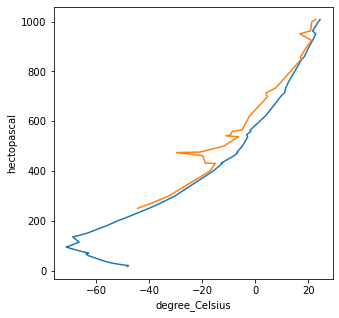

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(T, p)
ax.plot(Td, p)
plt.show()

y軸を対数にし，反転させて，目盛を付けるとエマグラム（偽断熱図）に近づいてきました。エマグラムは横軸に気温，縦軸に気圧の対数を取り，乾燥断熱線や湿潤断熱線，等飽和混合比線を描いたものです。

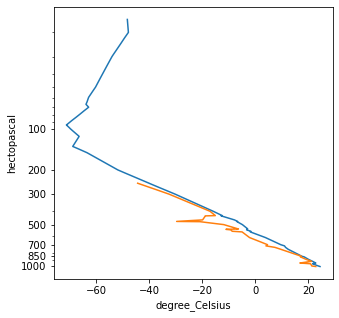

In [8]:
from matplotlib.ticker import ScalarFormatter
fig, ax = plt.subplots(figsize=(5, 5))
ax.semilogy(T, p)
ax.semilogy(Td, p)
ax.set_yticks([1000, 850, 700, 500, 300, 200, 100])
ax.get_yaxis().set_major_formatter(ScalarFormatter())
ax.invert_yaxis()

## 簡単なSkew-T図

Skew-T図は気温を45度傾け，縦軸に対数気圧をとったものです。気温を赤で，露点温度を緑で，風を黒の矢羽でSkew-Tに描いてみましょう。

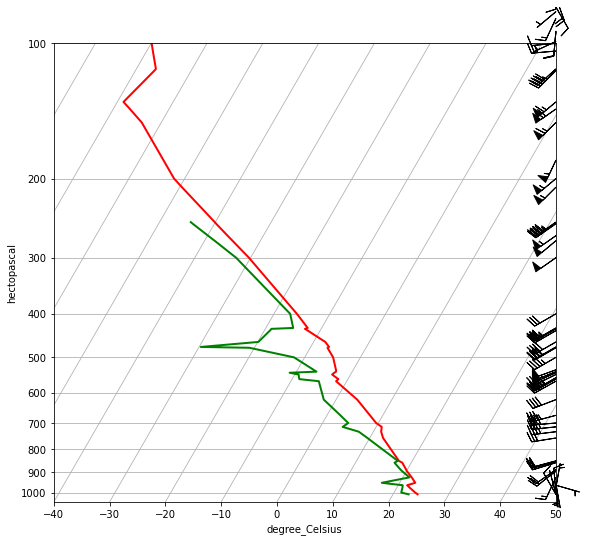

In [9]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)
plt.show()

## Skew-T図を完成させる

断熱線など様々な情報を追加してSkew-T図を完成させます。

* 6, 7行目: 図の範囲を指定します。
* 8行目: LCLを黒丸で示します。
* 9行目: 上で計算した気塊の上昇曲線を黒で描きます。
* 10, 11行目: 対流抑制（convective inhibition, CIN）と対流有効位置エネルギー（convective available potential energy, CAPE）をそれぞれ青，赤の陰影で示します。CAPE（CIN）は気塊の温度が気温の鉛直分布よりも高く（低く），正の（負の）浮力を持つ領域です。`skew_shade_cin()`に三つ目の引数`dewpoint`を与えると，LCLの下と中立高度（気塊の浮力が0となる高度）の上の陰影は描かれません。どちらもないとエラーになることがあります。

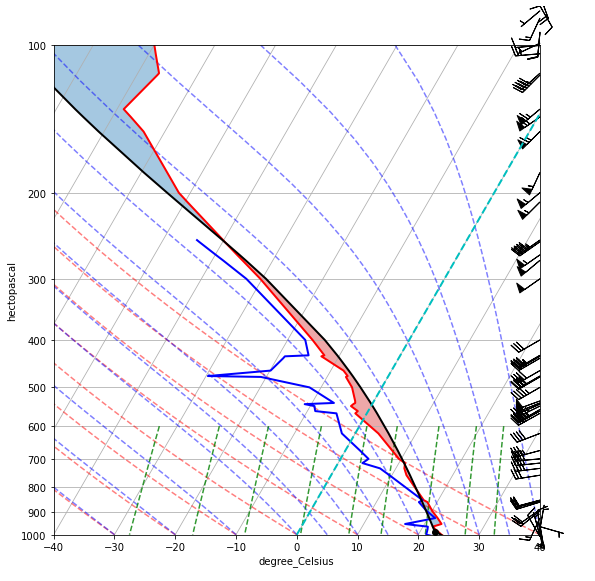

In [10]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'b', linewidth=2)
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 40)
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
skew.plot(p, parcel_prof, 'k', linewidth=2)
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
plt.show()

## ホドグラフの追加

ホドグラフは風の鉛直分布を極座標で表したものです。風は原点からのベクトルで表されます。縦軸からの角度は風向，原点からの距離は風速を表しています。ホドグラフは，ベクトルの先端を繋いで描かれます。

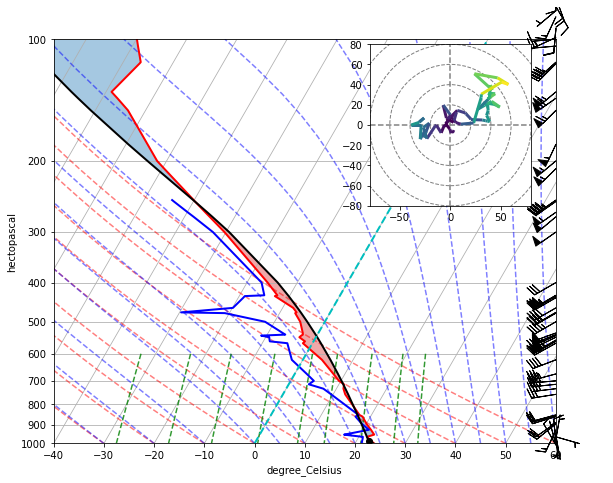

In [11]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'b', linewidth=2)
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
skew.plot(p, parcel_prof, 'k', linewidth=2)
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=80)
h.add_grid(increment=20)
h.plot_colormapped(u, v, wind_speed)
plt.show()